**Importing libraries and metrics which I used during the process of prediction.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Data reading

In [2]:
df = pd.read_parquet("AirPressure-main/data/data.parquet", engine='auto')

In [3]:
df.tail()

,MachineId,MeasurementId,Pressure
18466359,10_0_3,8834,0.0
18466360,10_0_3,8834,0.0
18466361,10_0_3,8834,0.0
18466362,10_0_3,8834,0.0
18466363,10_0_3,8834,0.0


In [4]:
labels_df = pd.read_csv ("AirPressure-main/data/labels.csv")

In [5]:
labels_df.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


In [7]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


**Define a function that counts values in my dataframes. This allows me to see the data and how many occurences there are**

In [8]:
def print_value_counts(df):
    for column in df.columns:
        print(f"Value counts for column '{column}':")
        print(df[column].value_counts())
        print("\n")

In [9]:
print_value_counts(df)

Value counts for column 'MachineId':
MachineId
0_2_0     610331
0_2_1     610331
0_2_2     610331
0_2_3     610331
0_1_3     418016
           ...  
22_0_0       231
67_2_0       226
67_2_1       226
67_2_2       226
67_2_3       226
Name: count, Length: 556, dtype: int64


Value counts for column 'MeasurementId':
MeasurementId
-1       5271331
 2845       4776
 3916       4768
 5659       4760
 4795       4748
          ...   
 6031        202
 6045        196
 6105        156
 6028        142
 5086         93
Name: count, Length: 8836, dtype: int64


Value counts for column 'Pressure':
Pressure
0.000000    10911129
1.000000        6602
0.655172        2280
0.689655        2242
0.675676        2241
              ...   
2.212308           1
2.046154           1
1.832375           1
1.936782           1
1.772989           1
Name: count, Length: 386064, dtype: int64




In [10]:
print_value_counts(labels_df)

Value counts for column 'MachineId':
MachineId
0_2_1     970
0_2_2     948
0_2_3     917
0_2_0     867
0_1_2     672
         ... 
79_2_3      1
79_2_2      1
79_2_1      1
79_2_0      1
78_0_3      1
Name: count, Length: 556, dtype: int64


Value counts for column 'MeasurementId':
MeasurementId
-1       485
 8813      4
 8812      4
 8810      4
 8807      4
        ... 
 843       1
 842       1
 8823      1
 17        1
 8798      1
Name: count, Length: 8836, dtype: int64


Value counts for column 'PumpFailed':
PumpFailed
False    23958
True      2942
Name: count, dtype: int64


Value counts for column 'SlowStart':
SlowStart
False    18249
True      1051
Name: count, dtype: int64


Value counts for column 'SlowEnd':
SlowEnd
False    15477
True      3823
Name: count, dtype: int64




**Defining another function that allows me to calculate missing percentage in my dataframes and print hte values**

In [11]:
def missing_percentage(dataframe):
    for column in dataframe.columns:
        percent_missing = np.mean(dataframe[column].isna()) *100
        print(f'{column} - {percent_missing}%')
missing_percentage(df)

MachineId - 0.0%
MeasurementId - 0.0%
Pressure - 0.0%


In [12]:
missing_percentage(labels_df)

MachineId - 0.0%
MeasurementId - 0.0%
PumpFailed - 1.771042541537338%
SlowStart - 29.523461749132736%
SlowEnd - 29.523461749132736%


## Data Cleaning

### Remove NaN

In [13]:
measurement_check = labels_df[labels_df['MeasurementId'] == -1]
all_nan = measurement_check[['PumpFailed', 'SlowStart', 'SlowEnd']].isna().all().all()

**This is telling me that all measurements with MeasurementId == -1 have values missing. This is good candidate for droping the rows.**

In [14]:
print(all_nan)

True


In [15]:
measurement_check.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
1,0_0_1,-1,NaN,NaN,NaN
4,0_1_0,-1,NaN,NaN,NaN
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
9,1_0_1,-1,NaN,NaN,NaN


In [16]:
all_nan_count = measurement_check[['PumpFailed', 'SlowStart', 'SlowEnd']].isna().all(axis=1).sum()
print(all_nan_count)

485


In [17]:
labels_df = labels_df[labels_df['MeasurementId'] != -1]

In [18]:
labels_df.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
5,0_1_1,1,True,False,False
8,1_0_0,2,False,True,False


In [19]:
missing_percentage(labels_df)

MachineId - 0.0%
MeasurementId - 0.0%
PumpFailed - 0.0%
SlowStart - 28.25278810408922%
SlowEnd - 28.25278810408922%


- **Here I removed NaN values for pump failed by droping the rows with what appears as faulty mesurement (odd id, missing values for all columns). By removing this data, I can use only data which provide actual value.**

### Substituting values

In [20]:
slow_start_check = labels_df[labels_df['SlowStart'].isna()]


In [21]:
slow_start_check.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
95,6_0_0,28,True,NaN,NaN
96,6_0_1,28,True,NaN,NaN
97,6_0_2,28,True,NaN,NaN
98,6_0_3,28,True,NaN,NaN
99,6_0_0,29,True,NaN,NaN


- **Now I'm thinking, if PumpFailed is True, then I probably won't have SlowStart or SlowEnd values (because pump failed and I don't have that data available). So let's check the assumption:**

In [22]:
pump_failed_true = labels_df[labels_df['PumpFailed'] == True]
condition_isna = pump_failed_true.apply(lambda row: pd.isna(row['SlowStart']) and pd.isna(row['SlowEnd']), axis=1)

In [23]:
pump_failed_true[condition_isna]

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
95,6_0_0,28,True,NaN,NaN
96,6_0_1,28,True,NaN,NaN
97,6_0_2,28,True,NaN,NaN
98,6_0_3,28,True,NaN,NaN
99,6_0_0,29,True,NaN,NaN
...,...,...,...,...,...
8098,4_2_2,3120,True,NaN,NaN
8120,0_2_1,3128,True,NaN,NaN
8121,0_2_2,3128,True,NaN,NaN
8149,4_2_1,3137,True,NaN,NaN


In [24]:
count_nan = condition_isna.sum()
print(count_nan)

782


In [25]:
count_other = len(condition_isna) - count_nan
print(count_other)

2160


- **I was not correct. There are values if PumpFailed == True. Only 782 values are missing if the condition is true. But let's check those where PumpFailed == True, but the SlowStart/SlowEnd are not missing.**

In [26]:
false_rows = pump_failed_true[~condition_isna]

In [27]:
false_rows.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
3,0_0_3,0,True,False,False
5,0_1_1,1,True,False,False
18,2_2_2,3,True,False,False
22,1_2_2,4,True,False,False
28,0_1_1,6,True,False,False


- **There can be another assumption: If PumpFailed is true, except values that are missing, SlowStart and SlowEnd would be marked as false because pump failed. If it didn't failed, then maybe we can record SlowStart or SlowEnd.**
    - To verify this assumption I check if rows where PumpFailed == True for columns SlowEnd/SlowStart contain values with true (pump failed so there shouldn't be any)
- **If I'm correct, I can also replace all values with NaN as false, because SlowStart and SlowEnd cannot be recored due to pump failure. Let's check this assumption**


In [28]:
condition_true = pump_failed_true.apply(lambda row: (row['SlowStart'] == True) or (row['SlowEnd'] == True), axis=1) 

In [29]:
count_condition_true = condition_true.sum()
count_condition_not_met = len(condition_true)-count_condition_true
print(count_condition_true)
print(count_condition_not_met)

2
2940


**To summarize if PumpFailed == True:**
 - Number of Slowstart | SlowEnd == True recorded: 2
 - Number of NaN records: 782
 - Number of False records : 2158
 - Total pumps failed: 2942

In [30]:
test = pump_failed_true[pump_failed_true['SlowEnd'] == True]

In [31]:
test.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
2564,2_2_1,1065,True,False,True
4362,0_0_3,1808,True,False,True


- **I'm not 100% correct. It seems to be that if the pump failed it still can have measurment for slow start or slow end.**
- I will do quick checkup when I merge the dataframes, how many values I can influence.

In [32]:
test_merge = pd.merge(df, labels_df, on=['MachineId', 'MeasurementId'])
test_merge

,MachineId,MeasurementId,Pressure,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,0.0,False,False,False
1,0_0_0,0,0.0,False,False,False
2,0_0_0,0,0.0,False,False,False
3,0_0_0,0,0.0,False,False,False
4,0_0_0,0,0.0,False,False,False
...,...,...,...,...,...,...
13195028,10_0_3,8834,0.0,False,False,False
13195029,10_0_3,8834,0.0,False,False,False
13195030,10_0_3,8834,0.0,False,False,False
13195031,10_0_3,8834,0.0,False,False,False


In [33]:
missing_percentage(test_merge)

MachineId - 0.0%
MeasurementId - 0.0%
Pressure - 0.0%
PumpFailed - 0.0%
SlowStart - 27.183274191129343%
SlowEnd - 27.183274191129343%


In [34]:
pump_failed_true = test_merge[test_merge['PumpFailed'] == True]
condition_isna = pump_failed_true.apply(lambda row: pd.isna(row['SlowStart']) and pd.isna(row['SlowEnd']), axis=1)

In [35]:
count_nan = condition_isna.sum()
print(count_nan)

360954


In [36]:
count_other = len(condition_isna) - count_nan
print(count_other)

1099266


In [37]:
condition_true = pump_failed_true.apply(lambda row: (row['SlowStart'] == True) or (row['SlowEnd'] == True), axis=1) 

In [38]:
count_condition_true = condition_true.sum()
count_condition_not_met = len(condition_true)-count_condition_true
print(count_condition_true)
print(count_condition_not_met)

1108
1459112


**Fact is that I probably influence around 1108 values, which is based on the data size not so significant number.**
- **I will try to make it simple and substitute all NaN values in SlowStar and SlowEnd values with False if PumpFailed == True**

In [39]:
condition = (labels_df['PumpFailed'] == True) & (labels_df['SlowStart'].isna() | labels_df['SlowEnd'].isna())
labels_df.loc[condition, ['SlowStart', 'SlowEnd']] = labels_df.loc[condition, ['SlowStart', 'SlowEnd']].fillna(False)

C:\Users\jakub\AppData\Local\Temp\ipykernel_8552\1618455829.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df.loc[condition, ['SlowStart', 'SlowEnd']] = labels_df.loc[condition, ['SlowStart', 'SlowEnd']].fillna(False)


In [40]:
labels_df.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
5,0_1_1,1,True,False,False
8,1_0_0,2,False,True,False


In [41]:
missing_percentage(labels_df)

MachineId - 0.0%
MeasurementId - 0.0%
PumpFailed - 0.0%
SlowStart - 25.3457249070632%
SlowEnd - 25.3457249070632%


- **I reduced the number of NaN values by 3%**

### Cleaning SlowStart and SlowEnd

In [42]:
slow_start_check = labels_df[labels_df['SlowStart'].isna()]


In [43]:
slow_start_check

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
494,6_2_3,181,False,NaN,NaN
1161,3_2_0,491,False,NaN,NaN
1166,3_2_0,494,False,NaN,NaN
1168,3_2_3,494,False,NaN,NaN
1192,3_2_3,501,False,NaN,NaN
...,...,...,...,...,...
23376,0_0_3,7642,False,NaN,NaN
23377,0_0_0,7643,False,NaN,NaN
23378,0_0_1,7643,False,NaN,NaN
23379,0_0_2,7643,False,NaN,NaN


In [44]:
slow_end_check= labels_df[labels_df['SlowEnd'].isna()]


In [45]:
slow_end_check

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
494,6_2_3,181,False,NaN,NaN
1161,3_2_0,491,False,NaN,NaN
1166,3_2_0,494,False,NaN,NaN
1168,3_2_3,494,False,NaN,NaN
1192,3_2_3,501,False,NaN,NaN
...,...,...,...,...,...
23376,0_0_3,7642,False,NaN,NaN
23377,0_0_0,7643,False,NaN,NaN
23378,0_0_1,7643,False,NaN,NaN
23379,0_0_2,7643,False,NaN,NaN


- **Here I was trying to make sense of remaining NaNs. I tried to group according MeasuremntId or MachineId but it does not provide any additional information that can help me remove NaNs. Therefore, I'm left with 2 options:**
    - Remove NaNs by assigning them value = False. I'm assuming there weren't issues when no indication was recorded.
    - Leave NaNs, which represent actual missing record.
    - Impute with values after mergind dataframes
- **I will try to merge dataframes and see if I can make sense out of it**

## Testing hypothesis

In [46]:
test_merge = pd.merge(df, labels_df, on=['MachineId', 'MeasurementId'])
test_merge

,MachineId,MeasurementId,Pressure,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,0.0,False,False,False
1,0_0_0,0,0.0,False,False,False
2,0_0_0,0,0.0,False,False,False
3,0_0_0,0,0.0,False,False,False
4,0_0_0,0,0.0,False,False,False
...,...,...,...,...,...,...
13195028,10_0_3,8834,0.0,False,False,False
13195029,10_0_3,8834,0.0,False,False,False
13195030,10_0_3,8834,0.0,False,False,False
13195031,10_0_3,8834,0.0,False,False,False


In [47]:
missing_percentage(test_merge)

MachineId - 0.0%
MeasurementId - 0.0%
Pressure - 0.0%
PumpFailed - 0.0%
SlowStart - 24.447744844594173%
SlowEnd - 24.447744844594173%


In [48]:
test_df = test_merge.groupby('MeasurementId')

In [49]:
test_df.head()

,MachineId,MeasurementId,Pressure,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,0.0,False,False,False
1,0_0_0,0,0.0,False,False,False
2,0_0_0,0,0.0,False,False,False
3,0_0_0,0,0.0,False,False,False
4,0_0_0,0,0.0,False,False,False
...,...,...,...,...,...,...
13193989,10_0_0,8834,0.0,False,False,False
13193990,10_0_0,8834,0.0,False,False,False
13193991,10_0_0,8834,0.0,False,False,False
13193992,10_0_0,8834,0.0,False,False,False


In [50]:
test_merge.describe(include='all')

,MachineId,MeasurementId,Pressure,PumpFailed,SlowStart,SlowEnd
count,13195033,1.319503e+07,1.319503e+07,13195033,9969145,9969145
unique,374,NaN,NaN,2,2,2
top,0_2_1,NaN,NaN,False,False,False
freq,483156,NaN,NaN,11734813,9392244,8064103
mean,NaN,4.756435e+03,3.629691e-01,NaN,NaN,NaN
std,NaN,2.509541e+03,5.107572e-01,NaN,NaN,NaN
min,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,NaN,2.668000e+03,0.000000e+00,NaN,NaN,NaN
50%,NaN,4.854000e+03,0.000000e+00,NaN,NaN,NaN
75%,NaN,6.964000e+03,7.725275e-01,NaN,NaN,NaN


In [51]:
test_merge['SlowStart'] = test_merge['SlowStart'].astype(float)
test_merge['SlowEnd'] = test_merge['SlowEnd'].astype(float)

In [52]:
corr = test_merge.corr()

Corr Matrix:
               MachineId  MeasurementId  Pressure  PumpFailed  SlowStart  \
MachineId       1.000000      -0.156946 -0.015521    0.098534   0.077620   
MeasurementId  -0.156946       1.000000  0.022692   -0.447911  -0.069807   
Pressure       -0.015521       0.022692  1.000000   -0.020256  -0.013313   
PumpFailed      0.098534      -0.447911 -0.020256    1.000000  -0.102669   
SlowStart       0.077620      -0.069807 -0.013313   -0.102669   1.000000   
SlowEnd        -0.195778       0.132906 -0.041994   -0.200548  -0.119909   

                SlowEnd  
MachineId     -0.195778  
MeasurementId  0.132906  
Pressure      -0.041994  
PumpFailed    -0.200548  
SlowStart     -0.119909  
SlowEnd        1.000000  


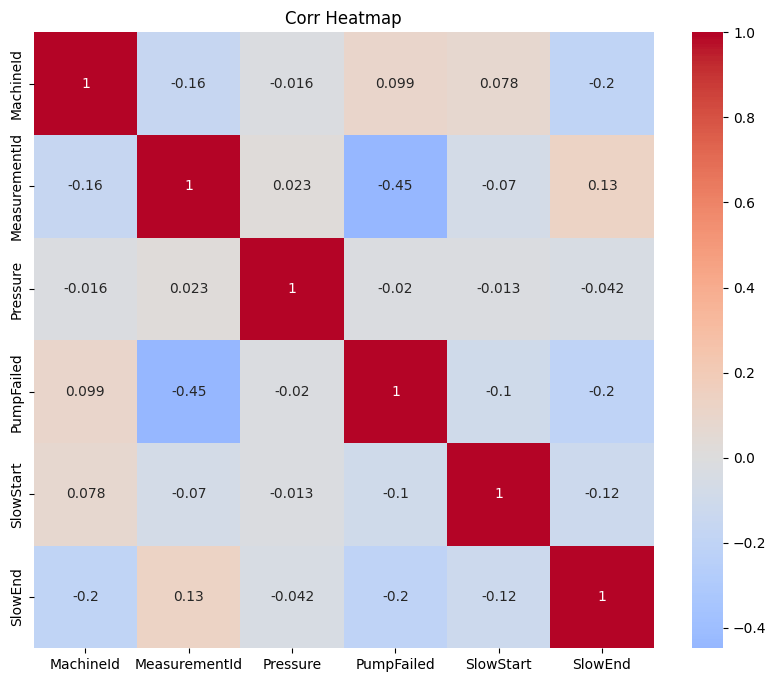

In [53]:
print("Corr Matrix:")
print(corr)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Corr Heatmap')
plt.show()

**I don't see any logical correlation to substitute the values in SlowStart and SlowEnd**
- **I decided to impute value with False**

## Merging dataframes and substituting values

In [54]:
merged_df = pd.merge(df, labels_df, on=['MachineId', 'MeasurementId'])
merged_df.columns

Index(['MachineId', 'MeasurementId', 'Pressure', 'PumpFailed', 'SlowStart',
       'SlowEnd'],
      dtype='object')

In [55]:
merged_df['SlowStart'] = merged_df['SlowStart'].fillna(False)
merged_df['SlowEnd'] = merged_df['SlowEnd'].fillna(False)

C:\Users\jakub\AppData\Local\Temp\ipykernel_8552\4046301311.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['SlowStart'] = merged_df['SlowStart'].fillna(False)
C:\Users\jakub\AppData\Local\Temp\ipykernel_8552\4046301311.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['SlowEnd'] = merged_df['SlowEnd'].fillna(False)


In [56]:
missing_percentage(merged_df)

MachineId - 0.0%
MeasurementId - 0.0%
Pressure - 0.0%
PumpFailed - 0.0%
SlowStart - 0.0%
SlowEnd - 0.0%


In [57]:
merged_df

,MachineId,MeasurementId,Pressure,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,0.0,False,False,False
1,0_0_0,0,0.0,False,False,False
2,0_0_0,0,0.0,False,False,False
3,0_0_0,0,0.0,False,False,False
4,0_0_0,0,0.0,False,False,False
...,...,...,...,...,...,...
13195028,10_0_3,8834,0.0,False,False,False
13195029,10_0_3,8834,0.0,False,False,False
13195030,10_0_3,8834,0.0,False,False,False
13195031,10_0_3,8834,0.0,False,False,False


## Model preparation

**I'll do train test split set (standard 20%) and then I test my model on it**

In [62]:
X = merged_df.drop(columns=['PumpFailed'])
y = merged_df['PumpFailed']

**I'm dividing columns into features based on type**

In [63]:
categorical_features = ['MachineId']
numerical_features = ['MeasurementId', 'Pressure']
binary_features = ['SlowStart', 'SlowEnd']

**I need to preprocess the categorical_features fot xgb model. Thus I create preprocessor** 

EDIT: I also added relevant imports to the top row in my ntb

In [64]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

**Preprocessor explanation**
 - Preprocessor is a pipeline that enables data transformation before I use it for machine learning. Pipeline is able to apply trasnformation to each type of features which I defined in steps.
 - One hot encoding -> this is a process where I need to convert categorical data such as MachineId which is represented as 8_0_3 etc. to numerical data that can be used for machine learning.
 - Result of pipeline is basically the input for next step, where I enter preprocessed data (X) and split the data, which I can use further in process

In [65]:
X_preprocessed = preprocessor.fit_transform(X)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

**I'm going to use 2 models and compare them**
- **Firstly I use Random Forest**
- **Then I will try to use Xgbboost**
- **Lastly I evaluate models**

In [67]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

In [68]:
smote = SMOTE(random_state=42)

# Step 4: Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

# Step 5: Combine SMOTE and Random Forest into a pipeline (no need to preprocess again)
pipeline = ImbPipeline(steps=[
    ('smote', smote),
    ('classifier', model)
])

# Step 6: Fit the pipeline
pipeline.fit(X_train, y_train)



KeyboardInterrupt: 

In [ ]:
# Step 7: Evaluate the model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

### Random forest

In [87]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

In [88]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [89]:
random_forest_y_pred = random_forest_model.predict(X_test)

### XGB boost

In [83]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state = 42, n_jobs=-1)

In [84]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [85]:
xgb_model_y_pred = xgb_model.predict(X_test)

In [90]:
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Recall: {recall*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")

# Evaluate Random Forest
print("Random Forest Performance:")
evaluate_model(y_test, random_forest_y_pred)

print("XGB Performance:")
evaluate_model(y_test, xgb_model_y_pred)

Random Forest Performance:
Accuracy: 71.1851%
Precision: 22.0994%
Recall: 63.4600%
F1 Score: 32.7826%
XGB Performance:
Accuracy: 90.1694%
Precision: 87.6525%
Recall: 13.0555%
F1 Score: 22.7261%


Based on the result of evaluete_model I would select RandomForest for further data prediction. It seems to be that this model is the most accurate, with high precision. 